In [2]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import get_stability_for_country, make_folium_map, wiki_change_factor

import warnings
warnings.filterwarnings('ignore')

import itertools

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

### Gather GDELT data
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
### this code is executed on the big server to obtain the results from 2011 to 2018 divided into 3 files per year
### for size.

import numpy as np
import pandas as pd
import gdelt # pip install gdelt
import gc

gd1 = gdelt.gdelt(version=1)
for i in range(11, 18):
    print('year : ', i , 1)
    results = gd1.Search(['20'+str(i)+' January 01','20'+str(i)+' May 01'],table='events')
    cols_to_keep = ['SQLDATE','ActionGeo_CountryCode','QuadClass' ]
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_QuadClass_20'+str(i)+'_1.pckl')
    del results
    gc.collect()
    print('year : ', i , 2)
    results = gd1.Search(['20'+str(i)+' May 01','20'+str(i)+' August 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_QuadClass_20'+str(i)+'_2.pckl')
    del results
    gc.collect()
    print('year : ', i , 3)
    if(i != 17):
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i+1)+' January 01'],table='events')
    else:
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i)+' December 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_QuadClass_20'+str(i)+'_3.pckl')
    del results
    gc.collect()

### Process GDELT Data (aggregate) 
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
from os import listdir
from os.path import isfile, join
import gc

def process_files():
    onlyfiles = [f for f in listdir('.') if isfile(join('.', f))]
    
    grouped = pd.DataFrame()
    for i, file in enumerate(onlyfiles):
        print('processing ', file)
        gc.collect()
        try:
            data = pd.read_pickle(file)
            data['Counter'] = 1.0
            data = data[['SQLDATE','ActionGeo_CountryCode', 'QuadClass', 'Counter']]
        except:
            continue;
        grouped = grouped.append([data.groupby(['SQLDATE','ActionGeo_CountryCode', 'QuadClass']).sum()])
        pd.to_pickle(grouped, str(i)+'_QuadClass.pckl')
        del data

### Show the gathered data

In [83]:
QuadClass_event_dic = {1:'Verbal Cooperation', 
                   2:'Material Cooperation', 
                   3:'Verbal Conflict', 
                   4:'Material Conflict', 
                   np.NaN:'',
                   0:'UNKNOWN'}


aggregated_gdelt = pd.read_pickle('data/20_QuadClass.pckl')
# clean the dataframe
aggregated_gdelt.reset_index(inplace=True)
# change names
aggregated_gdelt['QuadClass'] = aggregated_gdelt['QuadClass'].map(QuadClass_event_dic)
aggregated_gdelt.sort_values('SQLDATE', inplace=True)
# take only values above 2011
aggregated_gdelt = aggregated_gdelt[aggregated_gdelt['SQLDATE'] > 20110101]
# convert to Timestamp (takes lots of time)
aggregated_gdelt['SQLDATE'] = aggregated_gdelt['SQLDATE'].apply(lambda x: str(x) )
aggregated_gdelt['SQLDATE'] = aggregated_gdelt['SQLDATE'].apply(lambda x: pd.Timestamp(x).to_pydatetime())
pd.to_pickle(aggregated_gdelt, 'data/aggregated_gdelt_QuadClass.pckl')
aggregated_gdelt.head(20)

,SQLDATE,ActionGeo_CountryCode,QuadClass,Counter
151776,2011-01-02,NL,Material Conflict,27.0
151778,2011-01-02,NO,Material Cooperation,4.0
151779,2011-01-02,NO,Verbal Conflict,11.0
151777,2011-01-02,NO,Verbal Cooperation,41.0
151780,2011-01-02,NO,Material Conflict,12.0
151781,2011-01-02,NP,Verbal Cooperation,140.0
151782,2011-01-02,NP,Material Cooperation,18.0
151783,2011-01-02,NP,Verbal Conflict,39.0
151757,2011-01-02,MX,Verbal Conflict,33.0
151785,2011-01-02,NS,Verbal Cooperation,2.0


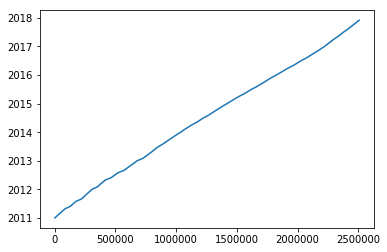

In [85]:
aggregated_gdelt = pd.read_pickle('data/aggregated_gdelt_QuadClass.pckl')

dates = aggregated_gdelt['SQLDATE'].values
cntr_codes = aggregated_gdelt['ActionGeo_CountryCode'].values
types = aggregated_gdelt['QuadClass'].values

plt.clf()
plt.plot(sorted(dates))
plt.show()

In [79]:
a, b = analyse_wiki_events_correlation('IR', 'Iran', '20110101000000', '20171215000000')
a, b

(0.13347298995346238, 0.7710029557061181)

In [82]:
a*b

0.1029080697610525

In [81]:
stab_factor,instab_factor,  mean, 

(250.0, 0.16946990833001196, 0.002362204724409449)

In [75]:
stab_factor, mean = get_stability_for_country( 'Iran', '20110101000000', '20171215000000')

In [80]:
instab_factor = wiki_change_factor( 'Iran', 2013, 2017, outlier_factor=3.4) 

In [25]:
from scipy.stats.stats import pearsonr

def get_country_values(cntr_code, start, stop, normalize=True):
    values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) >= pd.Timestamp(start)) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) <= pd.Timestamp(stop))];
    values_to_plot['ActionGeo_Type'] = 0;
    values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()
    values_to_plot.reset_index(inplace=True)
    if(normalize):
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
    else:
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']
    return x.values, y.values

def analyse_wiki_events_correlation(country_code, country_name, date_start, date_stop, plot=False):
    history_fetcher = HistoryFetcher(country_name)
    response = history_fetcher.get_history(date_start, date_stop)

    # Keeps only the date field for each edit
    fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))
    plt.figure(figsize=(15,7))
    
    bins_nr = int( (pd.Timestamp(date_stop) - pd.Timestamp(date_start) ).days/30.5  ) # 1mo per bar

    # Add historgram for the number of edits on ukraine's wikipedia page (normalized)
    n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                               bins=bins_nr,\
                                               normed=True,\
                                               color='blue',\
                                               alpha=0.5,\
                                               label='# of wiki edits '+country_name)
    
    plt.hold(True)

    fr_events_dates, w = get_country_values(country_code , date_start, date_stop)
    # Add histogram for the number of events (normalized)s
    n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                                  weights=w,
                                                  bins=bins_nr,\
                                                  color='green',\
                                                  normed=True,\
                                                  alpha=0.5,\
                                                  label='# events ' + country_name)

    if(plot == True):
        plt.xticks(rotation=45)
        plt.xlabel('Time in months')
        plt.ylabel('Normalized number of edits/events')
        plt.legend(loc='upper right')
        plt.title('Nr of Wiki Edits and GDELT Events for ' + country_name)
        plt.show()
        
    corr, non_sureness = pearsonr(n_event, n_wiki)
    
    return np.abs(corr), (1-non_sureness)
    

In [3]:
countries_data = pd.read_pickle('countries_data.pckl')
countries_data.head()

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,...,Perason Wiki/GDELT Events we,Perason Wiki/GDELT Events mo *sur,Perason Corr QuadClass1,Perason Corr QuadClass2,Perason Corr QuadClass3,Perason Corr QuadClass4,Pearson Corr QuadClass1,Pearson Corr QuadClass2,Pearson Corr QuadClass3,Pearson Corr QuadClass4
0,533.0,AA,ABW,Aruba,Americas,2.400000,0.023033,0.354108,105.264,88.6612,...,0.035040,0.002980,NaN,NaN,NaN,NaN,0.002634,0.014660,-0.022884,0.015593
1,28.0,AC,ATG,Antigua and Barbuda,Americas,3.303965,0.098758,0.257224,102.012,65.2,...,0.302105,0.244411,NaN,NaN,NaN,NaN,0.235806,0.274649,0.141033,0.255410
2,784.0,AE,ARE,United Arab Emirates,Asia,0.471846,0.036796,1.801133,9400.145,91.2434,...,NaN,0.023050,NaN,NaN,NaN,NaN,0.049526,-0.000536,-0.007324,0.000611
3,4.0,AF,AFG,Afghanistan,Asia,0.000000,0.000000,0.000000,35530.081,8.26,...,0.089826,0.150069,NaN,NaN,NaN,NaN,0.072509,0.187349,0.062449,0.260922
4,12.0,AG,DZA,Algeria,Africa,0.665484,0.100532,1.277054,41318.142,38.2,...,0.492696,0.512626,NaN,NaN,NaN,NaN,0.497177,0.524764,0.549691,0.517976


In [31]:
### fethcing all the data()

countries_data = pd.read_pickle('countries_data.pckl')
countries_data

#countries_data['Perason Wiki/GDELT Events mo *sur'] = np.NaN

for i, cntr_code in enumerate(sorted(list(set(cntr_codes)))):
    pd.to_pickle(countries_data,'countries_data.pckl')
    try:
        prev_val = countries_data[countries_data['FIPS']==cntr_code]['Perason Wiki/GDELT Events mo *sur'].values[0]
    except:
        continue
    if str(prev_val).upper() == 'NAN':
        
        name = countries_data[countries_data['FIPS']==cntr_code]['Country'].values
        if(len(name) == 0):
            print('Processing ', cntr_code, 'NO CODE FOUND')

        print('Processing ', cntr_code, '-', name[0])

        if  len(str(name[0])) > 3:
            corr, sureness = analyse_wiki_events_correlation(cntr_code,name[0],'20110101000000', '20171215000000');
            countries_data.ix[countries_data['FIPS']==cntr_code,'Perason Wiki/GDELT Events mo *sur'] = corr * sureness ;
            print('Processed ', name[0] , 'corr : ', corr * sureness)

        else:
            print('Processed ', cntr_code , ' NaN CODE ')
    else:
        print(cntr_code,'Already processed.')
        
        
        

Processing  AA - Aruba
Processed  Aruba corr :  0.00297966381665
Processing  AC - Antigua and Barbuda
Processed  Antigua and Barbuda corr :  0.244411343431
Processing  AE - United Arab Emirates
Processed  United Arab Emirates corr :  0.0230502608718
Processing  AF - Afghanistan
Processed  Afghanistan corr :  0.15006895486
Processing  AG - Algeria
Processed  Algeria corr :  0.512626335958
Processing  AJ - Azerbaijan
Processed  Azerbaijan corr :  0.144147357664
Processing  AL - Albania
Processed  Albania corr :  0.0437615519295
Processing  AM - Armenia
Processed  Armenia corr :  0.000452808221881
Processing  AN - Andorra
Processed  Andorra corr :  0.0558129880402
Processing  AO - Angola
Processed  Angola corr :  0.220731012676
Processing  AR - Argentina
Processed  Argentina corr :  0.00176887707684
Processing  AS - Australia
Processed  Australia corr :  0.215757339925
Processing  AU - Austria
Processed  Austria corr :  0.190185443348
Processing  AV - nan
Processed  AV  NaN CODE 
Processi

Processed  Nicaragua corr :  0.140946181869
Processing  NZ - New Zealand
Processed  New Zealand corr :  0.103000339137
Processing  PA - Paraguay
Processed  Paraguay corr :  0.0803739268951
Processing  PE - Peru
Processed  Peru corr :  0.470972845416
Processing  PK - Pakistan
Processed  Pakistan corr :  0.0872624420383
Processing  PL - Poland
Processed  Poland corr :  0.37415325838
Processing  PM - Panama
Processed  Panama corr :  0.000231725465687
Processing  PO - Portugal
Processed  Portugal corr :  0.253703226538
Processing  PP - Papua New Guinea
Processed  Papua New Guinea corr :  0.304630708834
Processing  PU - Guinea-Bissau
Processed  Guinea-Bissau corr :  0.361201569268
Processing  QA - Qatar
Processed  Qatar corr :  0.0339311480135
Processing  RM - Marshall Islands
Processed  Marshall Islands corr :  0.041244309376
Processing  RO - Romania
Processed  Romania corr :  0.339121545976
Processing  RP - Philippines
Processed  Philippines corr :  0.280969747587
Processing  RQ - Puerto 

In [33]:
pd.to_pickle(countries_data,'countries_data.pckl')
countries_data.head()

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,Internet users[k],Big Internet,GDP,GDP per capita,stab to plot,Stability Truncated,Perason Wiki/GDELT Events,Perason Wiki/GDELT Events mo *sur
0,533,AA,ABW,Aruba,Americas,2.400000,0.023033,0.354108,105.264,88.661227,93.328354,0.0,26005.409405,247.049413,0.988417,1.000000,0.035040,0.002980
1,028,AC,ATG,Antigua and Barbuda,Americas,3.303965,0.098758,0.257224,102.012,65.200000,66.511824,0.0,14764.489509,144.732870,0.949338,1.000000,0.302105,0.244411
2,784,AE,ARE,United Arab Emirates,Asia,0.471846,0.036796,1.801133,9400.145,91.243406,8577.012446,1.0,40438.771500,4.301931,0.674155,0.471846,NaN,0.023050
3,004,AF,AFG,Afghanistan,Asia,0.000000,0.000000,0.000000,35530.081,8.260000,2934.784691,1.0,623.184798,0.017540,0.000000,0.000000,0.089826,0.150069
4,012,AG,DZA,Algeria,Africa,0.665484,0.100532,1.277054,41318.142,38.200000,15783.530244,1.0,4154.118319,0.100540,0.773680,0.665484,0.492696,0.512626


In [86]:
from scipy.stats.stats import pearsonr

def get_country_values(cntr_code, start, stop, normalize=True):
    values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) >= pd.Timestamp(start)) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) <= pd.Timestamp(stop))];
    values_to_plot['ActionGeo_Type'] = 0;
    values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()
    values_to_plot.reset_index(inplace=True)
    if(normalize):
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
    else:
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']
    return x.values, y.values

def analyse_wiki_events_correlation(country_code, country_name, date_start, date_stop, plot=False):
    history_fetcher = HistoryFetcher(country_name)
    response = history_fetcher.get_history(date_start, date_stop)

    # Keeps only the date field for each edit
    fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))
    plt.figure(figsize=(15,7))
    
    bins_nr = int( (pd.Timestamp(date_stop) - pd.Timestamp(date_start) ).days/30.5  ) # 1mo per bar

    # Add historgram for the number of edits on ukraine's wikipedia page (normalized)
    n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                               bins=bins_nr,\
                                               normed=True,\
                                               color='blue',\
                                               alpha=0.5,\
                                               label='# of wiki edits '+country_name)
    
    plt.hold(True)

    fr_events_dates, w = get_country_values(country_code , date_start, date_stop)
    # Add histogram for the number of events (normalized)s
    n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                                  weights=w,
                                                  bins=bins_nr,\
                                                  color='green',\
                                                  normed=True,\
                                                  alpha=0.5,\
                                                  label='# events ' + country_name)

    if(plot == True):
        plt.xticks(rotation=45)
        plt.xlabel('Time in months')
        plt.ylabel('Normalized number of edits/events')
        plt.legend(loc='upper right')
        plt.title('Nr of Wiki Edits and GDELT Events for ' + country_name)
        plt.show()
        
    corr, non_sureness = pearsonr(n_event, n_wiki)
    
    return np.abs(corr), (1-non_sureness)
    

In [133]:
def get_country_values_perQuadClass(cntr_code, start, stop):
    values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) >= pd.Timestamp(start)) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) <= pd.Timestamp(stop))]
    values_to_plot = values_to_plot[['SQLDATE','ActionGeo_CountryCode', 'QuadClass', 'Counter']]
    values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'QuadClass']).sum()

    val1 = values_to_plot[values_to_plot['QuadClass'] == 'Verbal Cooperation']
    val2 = values_to_plot[values_to_plot['QuadClass'] == 'Material Cooperation']
    val3 = values_to_plot[values_to_plot['QuadClass'] == 'Verbal Conflict']
    val4 = values_to_plot[values_to_plot['QuadClass'] == 'Material Conflict']

    x1 = val1['SQLDATE'].values
    y1 = (val1['Counter']/val1['Counter'].mean()).values

    x2 = val2['SQLDATE'].values
    y2 = (val2['Counter']/val2['Counter'].mean()).values

    x3 = val3['SQLDATE'].values
    y3 = (val3['Counter']/val3['Counter'].mean()).values

    x4 = val4['SQLDATE'].values
    y4 = (val4['Counter']/val4['Counter'].mean()).values
    
    sum_all = np.sum(y1) + np.sum(y2) + np.sum(y3) + np.sum(y4)
    try:
        s1 = np.sum(y1)/sum_all
        s2 = np.sum(y2)/sum_all
        s3 = np.sum(y3)/sum_all
        s4 = np.sum(y3)/sum_all
    except:
        s1 = 0
        s2 = 0
        s3 = 0
        s4 = 0
    return [x1, x2, x3, x4], [y1, y2, y3, y4], [s1,s2,s3,s4]



In [131]:
def analyse_wiki_events_correlation_QuadClass(country_code, country_name, date_start, date_stop, plot=False):
    history_fetcher = HistoryFetcher(country_name)
    response = history_fetcher.get_history(date_start, date_stop)

    # Keeps only the date field for each edit
    edits_dates = list(map(lambda revision: revision['timestamp'], response))
    plt.figure(figsize=(15,7))
    
    bins_nr = int( (pd.Timestamp(date_stop) - pd.Timestamp(date_start) ).days/30.5  ) # 1mo per bar
    
    # Add historgram for the number of edits on country's wikipedia page (normalized)
    n_wiki, bins_wiki, patches_wiki = plt.hist(edits_dates,\
                                               bins=bins_nr,\
                                               normed=True,\
                                               color='blue',\
                                               alpha=0.5,\
                                               label='# of wiki edits '+country_name)
    plt.hold(True)
    
    x, y, s = get_country_values_perQuadClass(country_code , date_start, date_stop)
    corrs = list()
    surreneses =list()
    for i in range(len(x)):

    
        # Add histogram for the number of events (normalized)s
        n_event, bins_event, patches_event = plt.hist(x[i],\
                                                      weights=y[i],
                                                      bins=bins_nr,\
                                                      normed=True,\
                                                      alpha=0.2,\
                                                      label='# events ' + country_name)
        corr, non_sureness = pearsonr(n_event, n_wiki)

        corrs.append(corr)
        surreneses.append(1-non_sureness)

    if(plot == True):
        plt.legend(['events type 1','events type 2','events type 3','events type 4', 'wiki'])
        plt.xticks(rotation=45)
        plt.xlabel('Time in months')
        plt.ylabel('Normalized number of edits/events')
        plt.legend(loc='upper right')
        plt.title('Nr of Wiki Edits and GDELT Events for ' + country_name)
        plt.show()
        
    return np.array(corrs)*np.array(surreneses), s
    

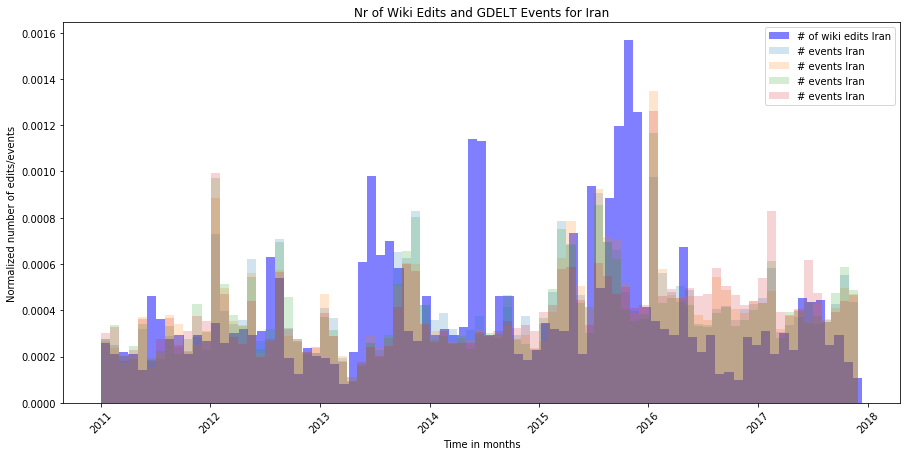

(array([ 0.14679504,  0.11795992,  0.03181405,  0.00081188]),
 [0.27251678629312343,
  0.2436327853669831,
  0.2363394304237092,
  0.2363394304237092])

In [132]:
analyse_wiki_events_correlation_QuadClass('IR', 'Iran', '20110101000000', '20171215000000', plot=True)

In [ ]:
analyse_wiki_events_correlation_QuadClass('PL', 'Poland', '20110101000000', '20171215000000', plot=True)

In [122]:
corrs = list()

In [126]:
corrs.append(1)
corrs

[1, 1, 1, 1]

In [134]:
countries_data = pd.read_pickle('countries_data.pckl')
countries_data

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,Internet users[k],Big Internet,GDP,GDP per capita,stab to plot,Stability Truncated,Perason Wiki/GDELT Events we,Perason Wiki/GDELT Events mo *sur
0,533.0,AA,ABW,Aruba,Americas,2.400000,0.023033,0.354108,105.264,88.6612,93.328354,0.0,26005.409405,247.049413,0.988417,1.000000,0.035040,0.002980
1,28.0,AC,ATG,Antigua and Barbuda,Americas,3.303965,0.098758,0.257224,102.012,65.2,66.511824,0.0,14764.489509,144.732870,0.949338,1.000000,0.302105,0.244411
2,784.0,AE,ARE,United Arab Emirates,Asia,0.471846,0.036796,1.801133,9400.145,91.2434,8577.012446,1.0,40438.771500,4.301931,0.674155,0.471846,NaN,0.023050
3,4.0,AF,AFG,Afghanistan,Asia,0.000000,0.000000,0.000000,35530.081,8.26,2934.784691,1.0,623.184798,0.017540,0.000000,0.000000,0.089826,0.150069
4,12.0,AG,DZA,Algeria,Africa,0.665484,0.100532,1.277054,41318.142,38.2,15783.530244,1.0,4154.118319,0.100540,0.773680,0.665484,0.492696,0.512626
5,31.0,AJ,AZE,Azerbaijan,Asia,0.700935,0.021414,1.212465,9827.589,77,7567.243530,1.0,5438.711061,0.553413,0.828206,0.700935,0.126276,0.144147
6,8.0,AL,ALB,Albania,Europe,0.364078,0.012492,2.334278,2930.187,63.2529,1853.429211,1.0,3984.234302,1.359720,0.599608,0.364078,0.049349,0.043762
7,51.0,AM,ARM,Armenia,Asia,1.495513,0.012870,0.568272,2930.450,58.2493,1706.967556,1.0,3489.127642,1.190646,0.993544,1.000000,0.078470,0.000453
8,20.0,AN,AND,Andorra,Europe,1.577287,0.010456,0.538810,76.965,96.91,74.586782,0.0,39896.376936,518.370388,0.994758,1.000000,0.050446,0.055813
9,24.0,AO,AGO,Angola,Africa,1.251043,0.011249,0.679320,29784.193,12.4,3693.239932,1.0,4714.065956,0.158274,0.994360,1.000000,0.145474,0.220731


In [144]:
### fethcing all the data()

countries_data['Pearson Corr QuadClass1'] = np.NaN
countries_data['Pearson Corr QuadClass2'] = np.NaN
countries_data['Pearson Corr QuadClass3'] = np.NaN
countries_data['Pearson Corr QuadClass4'] = np.NaN



for i, cntr_code in enumerate(sorted(list(set(cntr_codes)))):
    pd.to_pickle(countries_data,'countries_data.pckl')
    try:
        prev_val = countries_data[countries_data['FIPS']==cntr_code]['Pearson Corr QuadClass1'].values[0]
    except:
        continue
    if str(prev_val).upper() == 'NAN':
        
        name = countries_data[countries_data['FIPS']==cntr_code]['Country'].values
        if(len(name) == 0):
            print('Processing ', cntr_code, 'NO CODE FOUND')

        print('Processing ', cntr_code, '-', name[0])

        if  len(str(name[0])) > 3:
            corr, _ = analyse_wiki_events_correlation_QuadClass(cntr_code,name[0],'20110101000000', '20171215000000');
            countries_data.ix[countries_data['FIPS']==cntr_code,'Pearson Corr QuadClass1'] = corr[0] ;
            countries_data.ix[countries_data['FIPS']==cntr_code,'Pearson Corr QuadClass2'] = corr[1] ;
            countries_data.ix[countries_data['FIPS']==cntr_code,'Pearson Corr QuadClass3'] = corr[2] ;
            countries_data.ix[countries_data['FIPS']==cntr_code,'Pearson Corr QuadClass4'] = corr[3] ;
            print('Processed ', name[0] , 'corr : ', corr)

        else:
            print('Processed ', cntr_code , ' NaN CODE ')
    else:
        print(cntr_code,'Already processed.')
        

Processing  AA - Aruba
[ 0.00263424  0.01465992 -0.02288378  0.0155933 ]
Processed  Aruba corr :  [ 0.00263424  0.01465992 -0.02288378  0.0155933 ]
Processing  AC - Antigua and Barbuda
[ 0.23580558  0.27464914  0.14103313  0.25541004]
Processed  Antigua and Barbuda corr :  [ 0.23580558  0.27464914  0.14103313  0.25541004]
Processing  AE - United Arab Emirates
[ 0.04952583 -0.00053588 -0.00732353  0.00061132]
Processed  United Arab Emirates corr :  [ 0.04952583 -0.00053588 -0.00732353  0.00061132]
Processing  AF - Afghanistan
[ 0.07250873  0.1873494   0.06244916  0.26092188]
Processed  Afghanistan corr :  [ 0.07250873  0.1873494   0.06244916  0.26092188]
Processing  AG - Algeria
[ 0.4971767   0.52476397  0.5496912   0.51797644]
Processed  Algeria corr :  [ 0.4971767   0.52476397  0.5496912   0.51797644]
Processing  AJ - Azerbaijan
[ 0.15340197  0.1522232   0.06912243  0.11087037]
Processed  Azerbaijan corr :  [ 0.15340197  0.1522232   0.06912243  0.11087037]
Processing  AL - Albania
[ 0

[-0.19317129 -0.01523386 -0.11253425  0.00430993]
Processed  Equatorial Guinea corr :  [-0.19317129 -0.01523386 -0.11253425  0.00430993]
Processing  EN - Estonia
[ 0.06615634  0.08644598  0.09215296 -0.0027769 ]
Processed  Estonia corr :  [ 0.06615634  0.08644598  0.09215296 -0.0027769 ]
Processing  ER - Eritrea
[ 0.10190961  0.07961875  0.18703867  0.20077372]
Processed  Eritrea corr :  [ 0.10190961  0.07961875  0.18703867  0.20077372]
Processing  ES - El Salvador
[-0.11344651 -0.26617261 -0.19604026 -0.27269753]
Processed  El Salvador corr :  [-0.11344651 -0.26617261 -0.19604026 -0.27269753]
Processing  ET - Ethiopia
[ 0.06870142  0.09257657  0.08140713  0.08562817]
Processed  Ethiopia corr :  [ 0.06870142  0.09257657  0.08140713  0.08562817]
Processing  EZ - Czech Republic
[ 0.06455809  0.00023994  0.08291628  0.0003863 ]
Processed  Czech Republic corr :  [ 0.06455809  0.00023994  0.08291628  0.0003863 ]
Processing  FI - Finland
[-0.06191077 -0.17086345 -0.14076717 -0.0389415 ]
Proc

[-0.00833967 -0.02134985 -0.0006723  -0.01726665]
Processed  Monaco corr :  [-0.00833967 -0.02134985 -0.0006723  -0.01726665]
Processing  MO - Morocco
[-0.53867252 -0.50986887 -0.4190237  -0.51988716]
Processed  Morocco corr :  [-0.53867252 -0.50986887 -0.4190237  -0.51988716]
Processing  MP - Mauritius
[-0.17037213 -0.08044107 -0.11493247 -0.05663029]
Processed  Mauritius corr :  [-0.17037213 -0.08044107 -0.11493247 -0.05663029]
Processing  MR - Mauritania
[ 0.25389482  0.31775454  0.20988949  0.36356617]
Processed  Mauritania corr :  [ 0.25389482  0.31775454  0.20988949  0.36356617]
Processing  MT - Malta
[ 0.02775499  0.06692454  0.00976494  0.05030192]
Processed  Malta corr :  [ 0.02775499  0.06692454  0.00976494  0.05030192]
Processing  MU - Oman
[  3.91893438e-02  -8.50145616e-05   2.90917307e-01   1.97017989e-01]
Processed  Oman corr :  [  3.91893438e-02  -8.50145616e-05   2.90917307e-01   1.97017989e-01]
Processing  MV - Maldives
[ 0.22590819  0.35038445  0.35556704  0.13229259

[ 0.01202341  0.08274156 -0.00362889 -0.01439373]
Processed  Sao Tome and Principe corr :  [ 0.01202341  0.08274156 -0.00362889 -0.01439373]
Processing  TS - Tunisia
[ 0.5431609   0.584162    0.66091514  0.44934258]
Processed  Tunisia corr :  [ 0.5431609   0.584162    0.66091514  0.44934258]
Processing  TT - Timor-Leste
[-0.06414697 -0.02735459  0.0009805  -0.08916316]
Processed  Timor-Leste corr :  [-0.06414697 -0.02735459  0.0009805  -0.08916316]
Processing  TU - Turkey
[-0.06038838 -0.05041926 -0.02621635 -0.02701476]
Processed  Turkey corr :  [-0.06038838 -0.05041926 -0.02621635 -0.02701476]
Processing  TV - Tuvalu
[-0.01980041  0.06744026 -0.01670348 -0.00463323]
Processed  Tuvalu corr :  [-0.01980041  0.06744026 -0.01670348 -0.00463323]
Processing  TX - Turkmenistan
[-0.07544349  0.00049526 -0.00135244 -0.03058747]
Processed  Turkmenistan corr :  [-0.07544349  0.00049526 -0.00135244 -0.03058747]
Processing  UG - Uganda
[-0.20201086 -0.1855492  -0.02908467 -0.08389769]
Processed  

In [95]:
countries_data.dtypes

Code numeric                         float64
FIPS                                  object
Code                                  object
Country                               object
Region                                object
Wiki Stability MLE                   float64
Wiki Instability old                 float64
Wiki mean change day                 float64
Population[k]                        float64
Internet Users%                       object
Internet users[k]                    float64
Big Internet                         float64
GDP                                  float64
GDP per capita                       float64
stab to plot                         float64
Stability Truncated                  float64
Perason Wiki/GDELT Events we         float64
Perason Wiki/GDELT Events mo *sur    float64
Perason Corr QuadClass1              float64
Perason Corr QuadClass2              float64
Perason Corr QuadClass3              float64
Perason Corr QuadClass4              float64
Pearson Co

In [89]:
countries_data.head()

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,...,Perason Wiki/GDELT Events we,Perason Wiki/GDELT Events mo *sur,Perason Corr QuadClass1,Perason Corr QuadClass2,Perason Corr QuadClass3,Perason Corr QuadClass4,Pearson Corr QuadClass1,Pearson Corr QuadClass2,Pearson Corr QuadClass3,Pearson Corr QuadClass4
0,533.0,AA,ABW,Aruba,Americas,2.400000,0.023033,0.354108,105.264,88.6612,...,0.035040,0.002980,NaN,NaN,NaN,NaN,0.002634,0.014660,-0.022884,0.015593
1,28.0,AC,ATG,Antigua and Barbuda,Americas,3.303965,0.098758,0.257224,102.012,65.2,...,0.302105,0.244411,NaN,NaN,NaN,NaN,0.235806,0.274649,0.141033,0.255410
2,784.0,AE,ARE,United Arab Emirates,Asia,0.471846,0.036796,1.801133,9400.145,91.2434,...,NaN,0.023050,NaN,NaN,NaN,NaN,0.049526,-0.000536,-0.007324,0.000611
3,4.0,AF,AFG,Afghanistan,Asia,0.000000,0.000000,0.000000,35530.081,8.26,...,0.089826,0.150069,NaN,NaN,NaN,NaN,0.072509,0.187349,0.062449,0.260922
4,12.0,AG,DZA,Algeria,Africa,0.665484,0.100532,1.277054,41318.142,38.2,...,0.492696,0.512626,NaN,NaN,NaN,NaN,0.497177,0.524764,0.549691,0.517976


-0.00830440741885


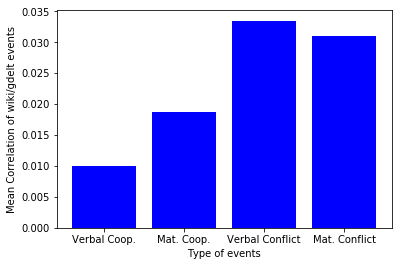

In [100]:
reg = 'Americas'
v1= countries_data[countries_data['Internet users[k]']  < 10000]['Pearson Corr QuadClass1'].mean()
v2= countries_data[countries_data['Internet users[k]']  < 10000]['Pearson Corr QuadClass2'].mean()
v3= countries_data[countries_data['Internet users[k]']  < 10000]['Pearson Corr QuadClass3'].mean()
v4= countries_data[countries_data['Internet users[k]']  < 10000]['Pearson Corr QuadClass4'].mean()
corr_values = [v1,v2,v3,v4]
minimum = np.min(corr_values)
corr_values = np.array(corr_values) - minimum +0.01
print(minimum)
plt.clf()
plt.bar(range(4), corr_values, color="blue")
plt.xticks(range(4),['Verbal Coop.','Mat. Coop.','Verbal Conflict','Mat. Conflict'])
plt.ylabel('Mean Correlation of wiki/gdelt events')
plt.xlabel('Type of events')
plt.show()